### MOE

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
# Load the dataset
file_path = 'reduced_sax_presnap.csv'
data = pd.read_csv(file_path)

# Drop irrelevant columns and handle missing target variable
data_cleaned = data.drop(columns=['Unnamed: 0', 'qbSneak'], errors='ignore')  # Drop columns
data_cleaned = data_cleaned.dropna(subset=['playOutcome'])  # Drop rows with missing playOutcome





In [20]:
# Encode the target variable if it is categorical
label_encoder = LabelEncoder()
data_cleaned['playOutcome'] = label_encoder.fit_transform(data_cleaned['playOutcome'])

# Separate features and target
X = data_cleaned.drop(columns=['playOutcome'])
y = data_cleaned['playOutcome']

# Select numeric features only
X = X.select_dtypes(include=['number'])

# Enhanced Imputation using KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = knn_imputer.fit_transform(X)


In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the expert models with simpler architectures for faster execution
expert_1 = MLPClassifier(hidden_layer_sizes=(32,), max_iter=300, alpha=0.01, random_state=42)
expert_2 = MLPClassifier(hidden_layer_sizes=(32,), max_iter=300, alpha=0.01, random_state=42)

# Train each expert on the training data
expert_1.fit(X_train_scaled, y_train)
expert_2.fit(X_train_scaled, y_train)

# Replace the gating network with Gradient Boosting
gating_network = GradientBoostingClassifier(random_state=42)
gating_network.fit(X_train_scaled, y_train)

# Get expert predictions on the test set
expert_1_test_probs = expert_1.predict_proba(X_test_scaled)
expert_2_test_probs = expert_2.predict_proba(X_test_scaled)

# Get gating network probabilities on the test set
gating_test_probs = gating_network.predict_proba(X_test_scaled)

# Combine expert predictions weighted by gating network
combined_expert_probs = (
    gating_test_probs[:, :, np.newaxis] * np.array([expert_1_test_probs, expert_2_test_probs]).transpose(1, 2, 0)
).sum(axis=-1)

# Final predictions based on combined expert probabilities
final_predictions = np.argmax(combined_expert_probs, axis=1)

# Evaluate the improved model
accuracy = accuracy_score(y_test, final_predictions)
classification_report_result = classification_report(y_test, final_predictions)

# Output results
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report_result)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 82.73%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       1.00      1.00      1.00         8
           2       0.83      1.00      0.91         5
           3       0.81      0.54      0.65        24
           4       0.80      0.84      0.82        38
           5       0.88      0.91      0.89        23
           6       1.00      0.62      0.76        13
           7       1.00      0.80      0.89        10
           8       1.00      0.70      0.82        10
           9       0.74      0.98      0.85        62
          10       1.00      0.67      0.80         9
          11       1.00      0.88      0.93         8
          12       0.00      0.00      0.00         0

    accuracy                           0.83       220
   macro avg       0.85      0.73      0.78       220
weighted avg       0.86      0.83      0.83       220



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# print column if it has missing values
print(data_cleaned.columns[data_cleaned.isnull().any()])



Index(['yardlineSide'], dtype='object')


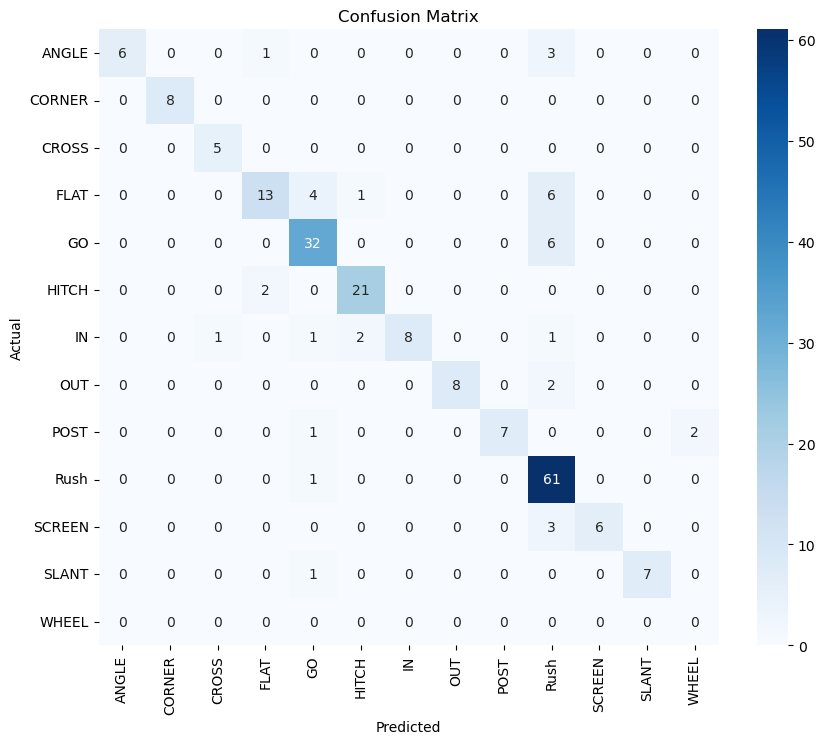

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


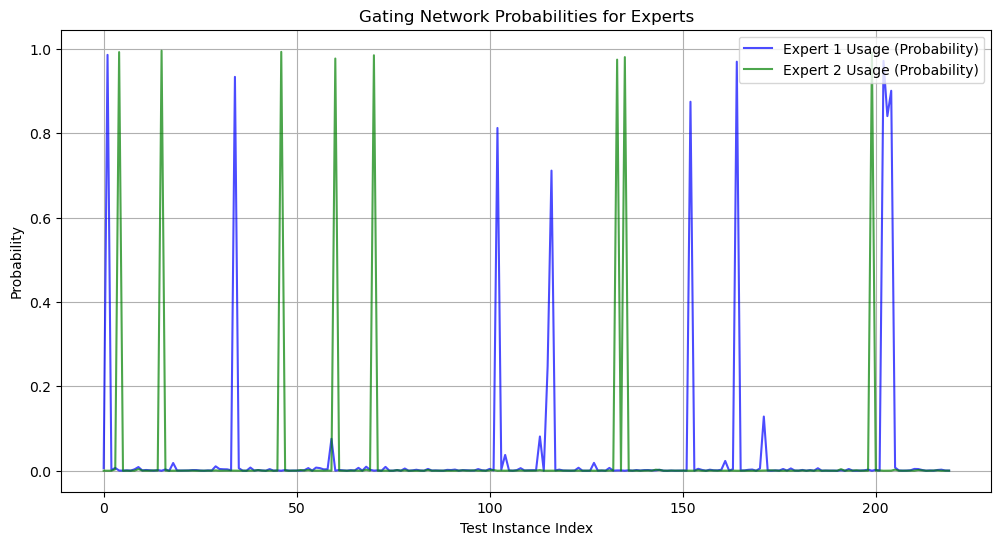

In [24]:
import matplotlib.pyplot as plt

# Get gating network probabilities for the test set
gating_test_probs = gating_network.predict_proba(X_test_scaled)

# Plot the probabilities assigned to each expert for each test instance
plt.figure(figsize=(12, 6))
plt.plot(gating_test_probs[:, 0], label="Expert 1 Usage (Probability)", color='blue', alpha=0.7)
plt.plot(gating_test_probs[:, 1], label="Expert 2 Usage (Probability)", color='green', alpha=0.7)

# Add labels and legend
plt.title("Gating Network Probabilities for Experts")
plt.xlabel("Test Instance Index")
plt.ylabel("Probability")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
